# Import some pkgs

In [2]:
import sys
sys.path.append("../../mypkg")

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict
from collections import defaultdict as ddict
from IPython.display import display

In [3]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [17]:
import importlib
import utils.measures
importlib.reload(utils.measures)

<module 'utils.measures' from '/data/rajlab1/user_data/jin/MyResearch/SBI-SGM-FC/notebooks/new_sgm/../../mypkg/utils/measures.py'>

In [18]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch
from utils.measures import geodesic_dist, reg_R_fn, lin_R_fn, lap_mat_fn

plt.style.use(FIG_ROOT/"base.mplstyle")

# Some fns

In [5]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x));
# transfer vec to a sym mat
def _vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

In [28]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr

def divide_fc(fc):
    """Divide the FC into three blocks and vector them
    """
    size_fc = len(fc)
    hs_fc = int(size_fc/2)
    fc_block1 = fc[:hs_fc, :hs_fc]
    fc_block2 = fc[hs_fc:, hs_fc:];
    fc_block3 = fc[:hs_fc, hs_fc:];
    vec1 = _minmax_vec(fc_block1[np.triu_indices(hs_fc, k = 1)])
    vec2 = _minmax_vec(fc_block2[np.triu_indices(hs_fc, k = 1)])
    vec3 = _minmax_vec(fc_block3.flatten())
    return vec1, vec2, vec3

def cal_metrics(fc1, fc2):
    """Calculate the distance between fc1 and fc2, including
        1. geodesic dist
        2. pearson's R
        3. lin R
        4. pearson's R after divide the FC into three blocks
        5. lin R after divide the FC into three blocks
    """
    fc1 = fc1.astype(np.float64)
    fc2 = fc2.astype(np.float64)
    size_fc = len(fc1)
    
    # for geodedic
    #fc1_g = fc1/np.linalg.norm(fc1) + np.eye(size_fc)
    #fc2_g = fc2/np.linalg.norm(fc2) + np.eye(size_fc)
    fc1_g = lap_mat_fn(fc1)
    fc2_g = lap_mat_fn(fc2)
    #fc1_g = fc1 + np.eye(size_fc)
    #fc2_g = fc2 + np.eye(size_fc)
    
    fc1_c = _minmax_vec(fc1[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    fc2_c = _minmax_vec(fc2[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    
    # all metrics
    geo_dist = geodesic_dist(fc1_g, fc2_g)
    reg_r = reg_R_fn(fc1_c, fc2_c)
    lin_r = lin_R_fn(fc1_c, fc2_c)
    mse = np.mean((fc1_c-fc2_c)**2)
    tau_r = kendalltau(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    sp_r = spearmanr(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    
    # block wise metrics
    blocks1 = divide_fc(fc1)
    blocks2 = divide_fc(fc2)
    reg_r_block = [reg_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    lin_r_block = [lin_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    
    res = edict()
    res.geo_dist = geo_dist
    res.reg_r = reg_r[0]
    res.lin_r = lin_r[0]
    res.tau_r = tau_r
    res.sp_r = sp_r 
    res.mse = mse
    res.reg_r_block = np.mean(reg_r_block)
    res.lin_r_block = np.mean(lin_r_block)
    return res

def cal_metrics_batch(fc1s, fc2s):
    """fc1s, fc2s: num_fc x 68 x 68
    """
    ress = ddict(list)
    for ix in range(len(fc1s)):
        fc_t = fc2s[ix]
        fc_e = fc1s[ix]
        res = cal_metrics(fc_t, fc_e)
        for key, v in res.items():
            ress[key].append(v)
    
    return ress

In [29]:
def _preprocess_sc(sc):
    sc = sc.copy()
    max_v = np.quantile(sc, 0.99);
    sc[sc>max_v] = max_v
    sc[sc <= 0.01*max_v] = 0
    return sc
def _preprocess_fc(fc):
    fc = fc.copy()
    fc[fc<=0.2*fc.max()] = 0
    return fc


# Load data

In [30]:
# em FC
fc_root = RES_ROOT/"emp_fcs"
def _get_fc(sub_ix, bd):
    fil = list(fc_root.rglob(f"*{bd}*/sub{sub_ix}.pkl"))[0]
    return load_pkl(fil, verbose=False)

In [31]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values;
scs = ind_conn.transpose(2, 0, 1)[:, :68, :68];
#scs = np.array([_preprocess_sc(sc) for sc in scs]);

# Compare them

In [32]:
bds = ["delta", "theta", "alpha", "beta_l"]
ress = []
for bd in bds:
    fcs = np.array([_get_fc(sub_ix, bd) for sub_ix in range(36)]);
    #fcs = np.array([_preprocess_fc(_get_fc(sub_ix, bd)) for sub_ix in range(36)]);
    res = cal_metrics_batch(fcs, scs);
    ress.append(res)

In [33]:
import pandas as pd
data = []
key_names = ['geo_dist', 'reg_r', 'tau_r', 'sp_r', 'lin_r', 'reg_r_block', "lin_r_block", "mse"]
for ix in range(len(bds)):
    for key in key_names:
        for value in ress[ix][key]:
            data.append({'Band': bds[ix], 'Key': key, 'Value': value})
df = pd.DataFrame(data);

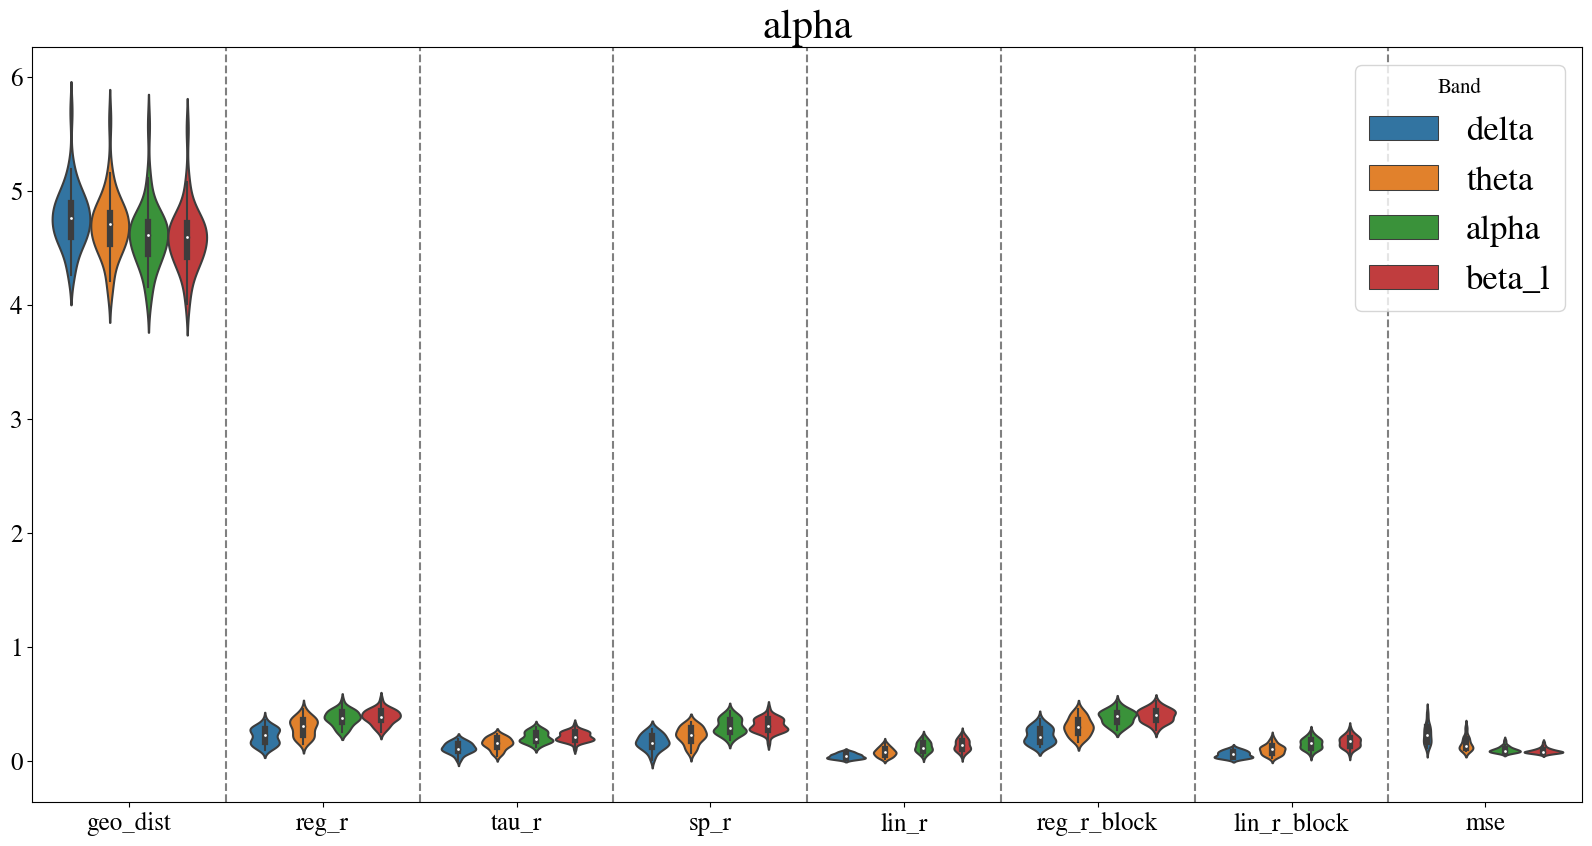

In [34]:
plt.figure(figsize=[20, 10])
plt.title(f"alpha", fontsize=30)
ax = sns.violinplot(x='Key', y='Value', hue='Band', data=df, split=False)
plt.xlabel("")
plt.ylabel("")

keys = df['Key'].unique()
for key_idx, key in enumerate(keys):
    if key_idx < len(keys) - 1:
        ax.axvline(x=key_idx + 0.5, color='grey', linestyle='--')
        
#plt.savefig(FIG_ROOT/f"{typ}_cmp.jpg")


In [35]:
from IPython.display import display
res_dict = {}
for ix in range(len(bds)):
    res = ress[ix]
    res_df = pd.DataFrame(res)
    res_dict[bds[ix]] = res_df.mean()
display(pd.DataFrame(res_dict))

,delta,theta,alpha,beta_l
geo_dist,4.766488,4.692101,4.606478,4.588435
reg_r,0.212883,0.293505,0.373770,0.385253
lin_r,0.040660,0.076625,0.123253,0.138048
tau_r,0.111218,0.150821,0.205604,0.212468
sp_r,0.165402,0.223066,0.302501,0.312134
mse,0.231275,0.149000,0.096527,0.085974
reg_r_block,0.221409,0.301520,0.381692,0.396712
lin_r_block,0.055886,0.097920,0.149381,0.166758


# Compare with our results

In [36]:
band = "alpha"
my_res = load_pkl(RES_ROOT/f"rawfc_posteriorMRmul_{band}_num1000_densitynsf_MR3_noise_sd20_addv1/inf_res_fb.pkl", 
               verbose=False);
estfcs = np.array(my_res.est_FCs);
empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);

my_res = pd.DataFrame(cal_metrics_batch(estfcs, empfcs));
sc_res = pd.DataFrame(cal_metrics_batch(scs, empfcs));
out_df = pd.DataFrame(
        {
            "SGM": my_res.mean(),
            "SC": sc_res.mean(), 
        }
    ).T
print(f"Results of {band}")
display(out_df)

Results of alpha


,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
SGM,0.784063,0.290822,0.246261,0.127966,0.190258,0.053723,0.241822,0.211380
SC,4.616643,0.373770,0.123253,0.205604,0.302501,0.096527,0.381692,0.149381


In [37]:
band = "theta"
my_res = load_pkl(RES_ROOT/f"rawfc_posteriorMRmul_{band}_num1000_densitynsf_MR3_noise_sd20_addv1/inf_res_fb.pkl", 
               verbose=False);
estfcs = np.array(my_res.est_FCs);
empfcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);

my_res = pd.DataFrame(cal_metrics_batch(estfcs, empfcs));
sc_res = pd.DataFrame(cal_metrics_batch(scs, empfcs));
out_df = pd.DataFrame(
        {
            "SGM": my_res.mean(),
            "SC": sc_res.mean(), 
        }
    ).T
print(f"Results of {band}")
display(out_df)

Results of theta


,geo_dist,reg_r,lin_r,tau_r,sp_r,mse,reg_r_block,lin_r_block
SGM,0.790865,0.283507,0.218515,0.128982,0.191213,0.078431,0.251034,0.20985
SC,4.703521,0.293505,0.076625,0.150821,0.223066,0.149000,0.301520,0.09792


# test

In [16]:
band = "alpha"
my_res = load_pkl(RES_ROOT/f"rawfc_posteriorMRmul_{band}_num1000_densitynsf_MR3_noise_sd20_addv1/inf_res.pkl", 
               verbose=False);
sub_ix = 3
efc = my_res.est_FCs[sub_ix];
ifc = _get_fc(sub_ix, band);
sc = scs[sub_ix];

_vec_fn = lambda mat: _minmax_vec(mat[np.triu_indices(68, k=1)])
efc_vec = _vec_fn(efc)
ifc_vec = _vec_fn(ifc)
sc_vec = _vec_fn(sc);

efc_vec1 = _vec_fn(_preprocess_fc(efc))
ifc_vec1 = _vec_fn(_preprocess_fc(ifc))
sc_vec1 = _vec_fn(_preprocess_sc(sc));

In [169]:
scipy.stats.pearsonr(ifc_vec[sc_vec!=-10], sc_vec[sc_vec!=-10])

(0.4480096766611223, 7.033890461450488e-113)

In [160]:
band = "alpha"
my_res = load_pkl(RES_ROOT/f"rawfc_posteriorMRmul_{band}_num1000_densitynsf_MR3_noise_sd20_addv1/inf_res.pkl", 
               verbose=False);
efcs = np.array(my_res.est_FCs);
ifcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);

In [161]:
pd.DataFrame(cal_metrics_batch(efcs, ifcs)).describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.627161,0.285600,0.240448,0.124302,0.184975,0.237528,0.207012
std,0.016989,0.082767,0.070253,0.032524,0.047853,0.075526,0.065017
min,0.585175,0.113538,0.103127,0.038988,0.058767,0.086488,0.082324
25%,0.616010,0.244604,0.196740,0.103237,0.152595,0.193869,0.169521
50%,0.629275,0.276417,0.250119,0.127124,0.188861,0.236184,0.202952
75%,0.640110,0.333783,0.271443,0.145482,0.215256,0.279507,0.242975
max,0.657530,0.483173,0.387977,0.187677,0.277141,0.425611,0.368555


In [162]:
pd.DataFrame(cal_metrics_batch(scs, ifcs)).describe()

,geo_dist,reg_r,lin_r,tau_r,sp_r,reg_r_block,lin_r_block
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.955312,0.375369,0.133652,0.206283,0.299211,0.382162,0.156303
std,0.034688,0.069027,0.062146,0.049340,0.067209,0.064009,0.055407
min,0.885379,0.249541,0.036368,0.120638,0.179114,0.270566,0.051819
25%,0.927842,0.334251,0.087323,0.170092,0.250662,0.334017,0.108561
50%,0.961014,0.374356,0.119927,0.193524,0.287496,0.389180,0.153587
75%,0.976399,0.429357,0.170380,0.239053,0.350443,0.420428,0.188663
max,1.024416,0.521907,0.319925,0.297938,0.436447,0.510752,0.297819
